![Nuclio logo](https://nuclio.school/wp-content/uploads/2018/12/nucleoDS-newBlack.png)

## 1. Librerias & Google Drive

Para empezar carguemos esas librerias que nos hacen falta

In [35]:
import tensorflow as tf
from tensorflow import keras as ks
from tensorflow.keras import regularizers
from tensorflow.keras.callbacks import EarlyStopping, LearningRateScheduler
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout, BatchNormalization, GlobalAveragePooling2D
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.preprocessing.image import ImageDataGenerator

from tensorflow.keras.applications import vgg16
from tensorflow.keras.models import Model

from matplotlib import pyplot as plt
import math
import numpy as np
import pandas as pd
import time
import datetime
import os.path
import random

In [36]:
# Aquí iria el codigo para conectarse a Google Drive
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [37]:
# Establecer la semilla :
np.random.seed(42)
tf.random.set_seed(42)

## 2. Preparacion de los datos

### CIFAR10

Cargamos los datos de CIFAR10 de los datasets directamente de las librerias de Keras. Estos ya estan dispuestos en train and test

**Detalle importante:**
> La red neuronal requiere que los inputs sean números reales, y lo haremos forzando la division de los valores de dentro de las matrices 28x28 (que tienen valoress del 0 al 255) por 255.0 (un real)

In [38]:
# Load and preprocess the CIFAR-10 dataset
cifar10 = ks.datasets.cifar10

(x_train, y_train), (x_test, y_test) = cifar10.load_data()

In [39]:
print("Etiquetas de train:", y_train)

# Convertir los datos en arrays de una dimension (vectores) es una buena mejora en el dataset
y_train = y_train.ravel()
y_test = y_test.ravel()

print("Etiquetas de train (en vector):", y_train)

Etiquetas de train: [[6]
 [9]
 [9]
 ...
 [9]
 [1]
 [1]]
Etiquetas de train (en vector): [6 9 9 ... 9 1 1]


Obtenemos un array con todas las labels de CIFAR10

In [40]:
cifar10_labels = [
'airplane', # id 0
'automobile',
'bird',
'cat',
'deer',
'dog',
'frog',
'horse',
'ship',
'truck'
]

print('Number of labels: %s' % len(cifar10_labels))

Number of labels: 10


Pintemos una muestra de las imagenes del dataset CIFAR10, a ver si se parece en algo a lo que esperamos.
Primero, vemos que tipos de datos tengo, después mapeamos esas matrices en una escala de grises utilizando el método **.get_cmap()** de PlotLy con los nueve primeros números del dataset.

Train: X=(50000, 32, 32, 3), y=(50000,)
Test: X=(10000, 32, 32, 3), y=(10000,)


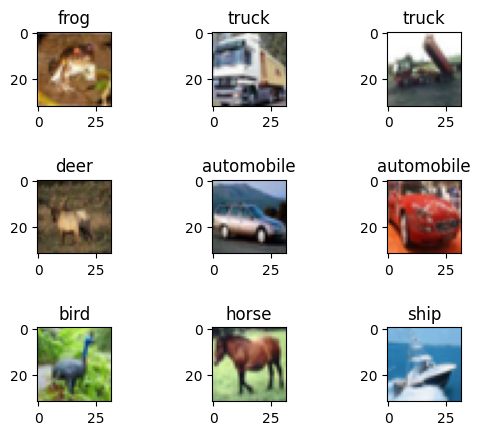

In [41]:
# Pintemos una muestra de las las imagenes del dataset MNIST
print('Train: X=%s, y=%s' % (x_train.shape, y_train.shape))
print('Test: X=%s, y=%s' % (x_test.shape, y_test.shape))

for i in range(9):
    plt.subplot(330 + 1 + i)
    plt.imshow(x_train[i], cmap=plt.get_cmap('gray'))
    plt.title(cifar10_labels[y_train[i]])

plt.subplots_adjust(hspace = 1)
plt.show()

Como vamos a querer ir haciendo validación a la vez que entrenamos (muy practico)

In [42]:
x_val = x_train[-10000:]
y_val = y_train[-10000:]

x_train = x_train[:-10000]
y_train = y_train[:-10000]

Cuando añadimos convoluciones, necesitamos "pre-tratar los datos", porque **la convolución espera una matriz de 4 campos** (más parecido a "imagenes"), en el caso de MNIST. CIFAR10 ya tiene el shape adecuado, así que no tenemos que hacer nada, pero como siempre decimos: es mejor que comprobeis su tamaño.

Por eso, al salir de la Convolution, hay que hacer un Flatten, porque las capas FullDense esperan arrays, no matrices!!

Luego lo imprimimos para ver que todo está correcto

In [43]:
# Validamos el resultado
print('Train: X=%s, y=%s' % (x_train.shape, y_train.shape))
print('Test: X=%s, y=%s' % (x_test.shape, y_test.shape))
print('Validation: X=%s, y=%s' % (x_val.shape, y_val.shape))

Train: X=(40000, 32, 32, 3), y=(40000,)
Test: X=(10000, 32, 32, 3), y=(10000,)
Validation: X=(10000, 32, 32, 3), y=(10000,)


In [44]:
x_train_scaled, x_val_scaled, x_test_scaled = x_train / 255.0, x_val /255.0, x_test / 255.0

## 3. Arquitectura de red del modelo

### 3.1. Cargar la parte de extraccion de features de VGG16

In [45]:
# Creemos una red que será extracción de features basada en VGG16
model_vgg16 = vgg16.VGG16(include_top = False,
                          weights = 'imagenet',
                          input_shape = (32,32,3))

# Añadir un Flatten en la última capa
output = model_vgg16.layers[-1].output
new_output_layer = ks.layers.Flatten()(output)
model_pre_vgg16 = Model(model_vgg16.input, new_output_layer)
model_pre_vgg16.summary()

Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 32, 32, 3)]       0         
                                                                 
 block1_conv1 (Conv2D)       (None, 32, 32, 64)        1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 32, 32, 64)        36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 16, 16, 64)        0         
                                                                 
 block2_conv1 (Conv2D)       (None, 16, 16, 128)       73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 16, 16, 128)       147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 8, 8, 128)         0   

In [46]:
pd.set_option("display.max_colwidth", True)
layers = [(layer, layer.name, layer.trainable) for layer in model_pre_vgg16.layers]
pd.DataFrame(layers, columns=("Layer","Name","Is Trainable?"))

,Layer,Name,Is Trainable?
0,<keras.engine.input_layer.InputLayer object at 0x7fe598bc94b0>,input_2,True
1,<keras.layers.convolutional.conv2d.Conv2D object at 0x7fe598818ac0>,block1_conv1,True
2,<keras.layers.convolutional.conv2d.Conv2D object at 0x7fe598bc9060>,block1_conv2,True
3,<keras.layers.pooling.max_pooling2d.MaxPooling2D object at 0x7fe598b7b0d0>,block1_pool,True
4,<keras.layers.convolutional.conv2d.Conv2D object at 0x7fe598bcb5b0>,block2_conv1,True
5,<keras.layers.convolutional.conv2d.Conv2D object at 0x7fe598b780d0>,block2_conv2,True
6,<keras.layers.pooling.max_pooling2d.MaxPooling2D object at 0x7fe598b79330>,block2_pool,True
7,<keras.layers.convolutional.conv2d.Conv2D object at 0x7fe598b7a830>,block3_conv1,True
8,<keras.layers.convolutional.conv2d.Conv2D object at 0x7fe598b7a7a0>,block3_conv2,True
9,<keras.layers.convolutional.conv2d.Conv2D object at 0x7fe598b78f70>,block3_conv3,True


### 3.3. Montemos la red de clasificación

In [47]:
# Definamos el output de salida de la transformacion VGG16
print(model_pre_vgg16.output_shape)
model_pre_vgg16_output = model_pre_vgg16.output_shape[1]
print(model_pre_vgg16_output)

(None, 512)
512


In [48]:
model_post_vgg16 = ks.Sequential()

model_post_vgg16.add(model_pre_vgg16)

# Capa completamente conectada
model_post_vgg16.add(Dense(256, activation='relu'))
model_post_vgg16.add(BatchNormalization())
model_post_vgg16.add(Dense(128, activation='relu'))
model_post_vgg16.add(BatchNormalization())
model_post_vgg16.add(Dropout(0.25))

# Capa de salida
model_post_vgg16.add(Dense(10, activation='softmax'))

In [49]:
model_post_vgg16.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 model_1 (Functional)        (None, 512)               14714688  
                                                                 
 dense_3 (Dense)             (None, 256)               131328    
                                                                 
 batch_normalization_2 (Batc  (None, 256)              1024      
 hNormalization)                                                 
                                                                 
 dense_4 (Dense)             (None, 128)               32896     
                                                                 
 batch_normalization_3 (Batc  (None, 128)              512       
 hNormalization)                                                 
                                                                 
 dropout_1 (Dropout)         (None, 128)              

### Definamos un optimizador

In [50]:
# Definir hiperparámetros
BATCH_SIZE = 256
EPOCHS = 50

In [51]:
# Crear una instancia del optimizador Adam
optimizer = Adam(learning_rate=1e-4,
                 clipnorm=1.0)

In [52]:
# Compilación del modelo
model_post_vgg16.compile(optimizer=optimizer,
                       loss='sparse_categorical_crossentropy',
                       metrics=['accuracy'])

### Definamos un callback para el Early Stopping

In [53]:
# Definir el callback de EarlyStopping
early_stopping_val_loss = EarlyStopping(monitor = 'val_loss',
                                        patience = 10,
                                        restore_best_weights = True)
early_stopping_val_accuracy = EarlyStopping(monitor = "val_accuracy",
                                            patience = 10,
                                            restore_best_weights = True)

In [54]:
## Step Decay: Reduce la tasa de aprendizaje por un factor en intervalos fijos.
#def step_decay(epoch, lr):
#    decay_rate = 0.2
#    decay_step = 5
#    if epoch % decay_step == 0 and epoch != 0:
#        lr = lr * decay_rate
#    return lr
#
## Define the callbacks
#lr_scheduler = LearningRateScheduler(step_decay)

## Data augmentation

In [55]:
# Definir el generador de aumento de datos para el conjunto de entrenamiento
train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=15,
    width_shift_range=0.1,
    height_shift_range=0.1,
    horizontal_flip=True,
    fill_mode='nearest')

# Ajustar el generador de aumento de datos a los datos de entrenamiento
train_datagen.fit(x_train)

In [56]:
# Ajustar el generador de aumento de datos a los datos de validación
validation_datagen = ImageDataGenerator(rescale=1./255)

## 5. Entrenamiento del modelo

In [57]:
t = time.perf_counter()

In [24]:
# Entrenamiento con Data Augmentation:
history = model_post_vgg16.fit(train_datagen.flow(x_train,
                                                  y_train,
                                                  batch_size = BATCH_SIZE),
                    epochs = EPOCHS,
                    callbacks = [early_stopping_val_loss, early_stopping_val_accuracy],
                    steps_per_epoch = math.ceil(len(x_train)/BATCH_SIZE),
                    validation_data = validation_datagen.flow(x_val,
                                                              y_val,
                                                              batch_size = BATCH_SIZE),
                    validation_steps = math.ceil(len(x_val)/BATCH_SIZE),
                    shuffle=True)

Epoch 1/50
157/157 [==============================] - 47s 180ms/step - loss: 1.2554 - accuracy: 0.5821 - val_loss: 1.2719 - val_accuracy: 0.5694
Epoch 2/50
157/157 [==============================] - 27s 171ms/step - loss: 0.7666 - accuracy: 0.7409 - val_loss: 0.6686 - val_accuracy: 0.7727
Epoch 3/50
157/157 [==============================] - 27s 172ms/step - loss: 0.6269 - accuracy: 0.7873 - val_loss: 0.6266 - val_accuracy: 0.7904
Epoch 4/50
157/157 [==============================] - 27s 171ms/step - loss: 0.5442 - accuracy: 0.8140 - val_loss: 0.6051 - val_accuracy: 0.8056
Epoch 5/50
157/157 [==============================] - 27s 171ms/step - loss: 0.4809 - accuracy: 0.8364 - val_loss: 0.5049 - val_accuracy: 0.8236
Epoch 6/50
157/157 [==============================] - 27s 169ms/step - loss: 0.4231 - accuracy: 0.8540 - val_loss: 0.4589 - val_accuracy: 0.8505
Epoch 7/50
157/157 [==============================] - 29s 181ms/step - loss: 0.3802 - accuracy: 0.8688 - val_loss: 0.4569 - val_ac

In [25]:
elapsed_time = datetime.timedelta(seconds=(time.perf_counter() - t))

print('Tiempo de entrenamiento:', elapsed_time)

Tiempo de entrenamiento: 0:09:42.279129


## 6. Evaluamos los resultados

Obtengamos una grafica de como el error y la accuracy van evolucionando en cada epoch en los datos de entrenamiento y en la validación

In [26]:
# Calcular las métricas
acc_train = model_post_vgg16.evaluate(x_train_scaled, y_train, verbose=0)[1]
acc_test = model_post_vgg16.evaluate(x_test_scaled, y_test, verbose=0)[1]
loss_train = model_post_vgg16.evaluate(x_train_scaled, y_train, verbose=0)[0]
loss_test = model_post_vgg16.evaluate(x_test_scaled, y_test, verbose=0)[0]

In [27]:
print('Accuracy (train): %.3f' % (acc_train * 100.0))
print('Accuracy (test): %.3f' % (acc_test * 100.0))

Accuracy (train): 95.335
Accuracy (test): 86.880


In [28]:
print('Cross Entropy Loss (train): %.3f' % loss_train)
print('Cross Entropy Loss (test): %.3f' % loss_test)

Cross Entropy Loss (train): 0.140
Cross Entropy Loss (test): 0.411


In [29]:
# Obtener la fecha y hora actual:
now = datetime.datetime.now()

# Crear un DataFrame con los resultados:
data = {'Fecha': [now],
        'Nombre del notebook': ['230703_6.2_cnn-cifar10.ipynb'],
        'Accuracy (train)': [acc_train],
        'Accuracy (test)': [acc_test],
        'Cross Entropy Loss (train)': [loss_train],
        'Cross Entropy Loss (test)': [loss_test]}

df = pd.DataFrame(data)

# Ubicación del archivo:
ruta_archivo = '/content/drive/MyDrive/NDS_2023/Isi/Entregable/CIFAR10_resultados.xlsx'

# Cargar el archivo existente si existe, de lo contrario, crear uno nuevo:
if os.path.exists(ruta_archivo):
    existing_df = pd.read_excel(ruta_archivo)
else:
    existing_df = pd.DataFrame()

# Agregar el nuevo DataFrame al DataFrame existente:
updated_df = existing_df.append(df)

# Guardar el DataFrame actualizado en el archivo de Excel:
updated_df.to_excel(ruta_archivo, index=False)


<ipython-input-29-7174bcf7eb93>:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  updated_df = existing_df.append(df)


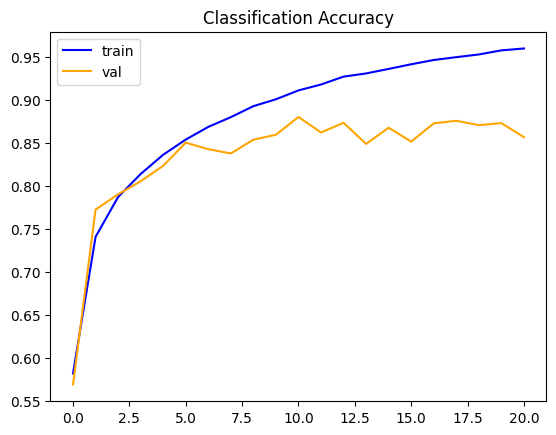

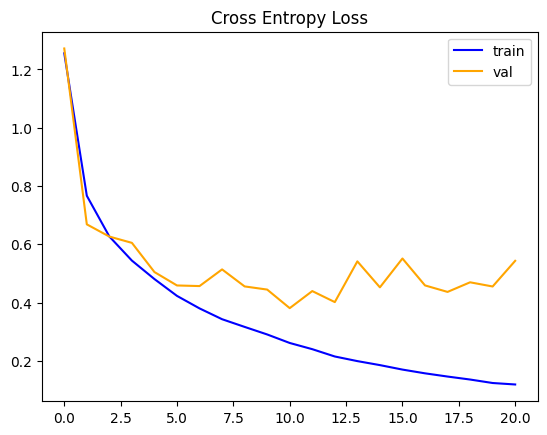

In [30]:
plt.title('Classification Accuracy')
plt.plot(history.history['accuracy'], color='blue', label='train')
plt.plot(history.history['val_accuracy'], color='orange', label='val')
plt.legend()
plt.show()

plt.title('Cross Entropy Loss')
plt.plot(history.history['loss'], color='blue', label='train')
plt.plot(history.history['val_loss'], color='orange', label='val')
plt.legend()
plt.show()

El coste podemos ver que es estable y es en el epoch 15 que se fija en un valor. Además la accuracy baila alrededor de 0.10. No se puede decir que sea un modelo muy bueno.

Veamos que tipo de predicciones estoy obteniendo sobre el conjunto de test (vamos a pintar las imagenes y sus clasificaciones)

In [31]:
predictions = model_post_vgg16.predict(x_test)

313/313 [==============================] - 2s 7ms/step


Una de las ventajas de Python es que hay montones de funciones y código realizado por terceras personas. Aquí me he fusilado unas bonitas funciones (que he adaptado un poco a mis necesidades) para poder pintar las imagenes, su label (ground truth) y las clasificaciones que hemos realizado.

In [32]:
def plot_image(i, predictions_array, true_label, img):
  predictions_array, true_label, img = predictions_array, true_label[i], img[i]
  plt.grid(False)
  plt.xticks([])
  plt.yticks([])

  plt.imshow(img, cmap=plt.cm.binary)

  predicted_label = np.argmax(predictions_array)
  if predicted_label == true_label:
    color = 'blue'
  else:
    color = 'red'

  plt.xlabel("{} {:2.0f}% ({})".format(predicted_label,
                                100*np.max(predictions_array),
                                true_label),
                                color=color)

def plot_value_array(i, predictions_array, true_label):
  predictions_array, true_label = predictions_array, true_label[i]
  plt.grid(False)
  plt.xticks(range(10))
  plt.yticks([])
  thisplot = plt.bar(range(10), predictions_array, color="#777777")
  plt.ylim([0, 1])
  predicted_label = np.argmax(predictions_array)

  thisplot[predicted_label].set_color('red')
  thisplot[true_label].set_color('blue')

Dibujamos las primeras imagenes, con las predicciones y sus valores reales (un total de 20 imagenes, para no abusar de vuestros laptops)

Coloreamos las prediciones correctas en azul y los fallos en rojo. Aunque primero he impreso las etiquetas para que tengamos una referencia al grafico.

0 airplane
1 automobile
2 bird
3 cat
4 deer
5 dog
6 frog
7 horse
8 ship
9 truck


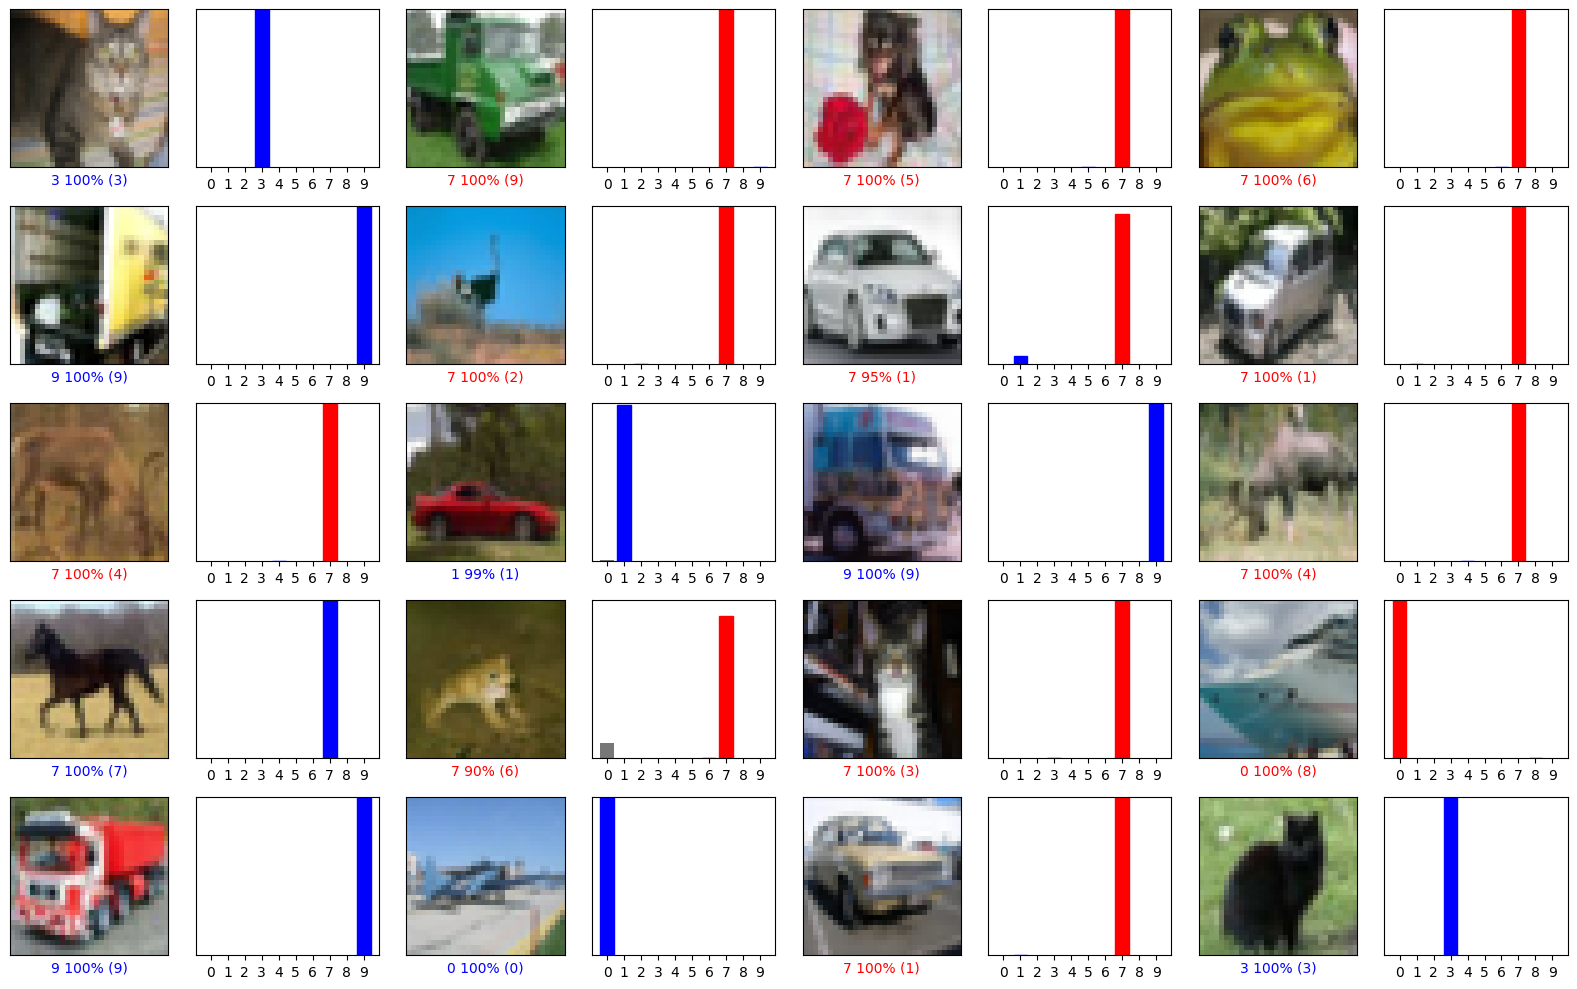

In [33]:
i = 0
for l in cifar10_labels:
    print(i, l)
    i += 1

num_rows = 5
num_cols = 4
start = 650
num_images = num_rows*num_cols
plt.figure(figsize=(2*2*num_cols, 2*num_rows))
for i in range(num_images):
  plt.subplot(num_rows, 2*num_cols, 2*i+1)
  plot_image(i+start, predictions[i+start], y_test, x_test)
  plt.subplot(num_rows, 2*num_cols, 2*i+2)
  plot_value_array(i+start, predictions[i+start], y_test)
plt.tight_layout()
plt.show()

## 7. Guardamos el modelo para futuras evaluaciones

Id cambiando los nombres del archivo para ir guardando los diversos proyectos.
Aquí lo guardamos en "local", pero recordad que lo ideal es que lo guardeis en Google Drive (teneis que montar la unidad, fijar la ruta y allí guardar el modelo .h5)

In [34]:
ruta_googledrive = "/content/drive/MyDrive/NDS_2023/Isi/Entregable/models/"

# Guardar el modelo
model_post_vgg16.save(ruta_googledrive + '230703_6.2_cnn-cifar10_model.h5')